# Рекомендация тарифов

## Цели и задачи

### Цель исследования
Построить модель для классификации, которая предлагает пользователям тариф «Ультра» или «Смарт» в зависимости от их поведения.

### Задачи исследования
1. Построить несколько моделей на основе имеющихся данных
2. Исследовать метрики качества моделей с разными гиперпараметрами
3. Выбрать оптимальную модель с наибольшим значением accuracy (не менее 0.75)
4. Проверить модель на тестовой выборке

## Обзор данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('/content/users_behavior.csv')

In [3]:
# размер датафрейма (строки, столбцы)
df.shape

(3214, 5)

In [4]:
# Количество пропусков и дубликатов
print(df.isna().sum())
print(df.duplicated().sum())

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64
0


In [5]:
# Общие статистические характеристики данных
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


In [6]:
# Изучим типы данных в столбцах
df.dtypes

calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra      int64
dtype: object

In [7]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Изменим тип данных в стобцах `messages` и `minutes`, т.к. эти столбцы содержат целочисленные значения.

In [8]:
df[['minutes', 'messages']] = df[['minutes', 'messages']].astype('int64')
df.dtypes

calls       float64
minutes       int64
messages      int64
mb_used     float64
is_ultra      int64
dtype: object

Наши данные не нуждаются в дальнейшей предобработке: пропуски и дубликаты отсутствуют, явных выбросов нет. Типы данных соответствуют значениям в столбцах.

Посмотрим, как распределились значения в столбце `is_ultra` (там хранятся данные о тарифе пользователя: `0` — тариф «Смарт», `1` — тариф «Ультра»).

In [9]:
df.is_ultra.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

### Вывод по разделу
1. Изменили тип данных в столбцах `messages` и `minutes` на целочисленный
2. Пропусков и дубликатов в таблице нет, данные корректны, пригодны для исследования
3. Среди пользователей, данные о которых содержатся в датафрейме, тариф «Ультра» — у 985 человек, тариф «Смарт» — у 2229 человек. Этот столбец будет нашим целевым признаком при построении модели.

## Разбиваем данные на выборки

Прежде чем приступать к обучению моделей, необходимо разбить данные на выборки. Т.к. тестовой выборки у нас нет, то будем исходить из пропорции 3:1:1, то есть 60% данных отведем под обучающую выборку, 20% — под валидационную (на которой мы будем проверять качество модели) и 20% — под тестовую (на которой будем тестировать готовую модель). При разбивке на выборки мы будем учитывать, что в наших целевых данных имеется дисбаланс (добавим параметр stratify, который будет учитывать эту несбалансированность при разбивке).

In [10]:
# Выделяем целевой признак по всей выборке
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

# Выделяем 60% обучающей выборки
features_train, features_test_val, target_train, target_test_val = (
    train_test_split(features, target, test_size=0.4, 
                     random_state=42, stratify=target)
)

# Делим оставшиеся 40% исходной выборки на валидационную и тестовую
features_val, features_test, target_val, target_test = (
    train_test_split(features_test_val, target_test_val, 
                     test_size=0.5, random_state=42, 
                     stratify=target_test_val)
)


In [11]:
# Проверим, корректно ли разбиты данные
print(features_train.shape)
print(features_val.shape)
print(features_test.shape)

(1928, 4)
(643, 4)
(643, 4)


### Вывод по разделу
Мы разбили исходные данные на три части: 
- 60% данных будут использоваться для обучения модели, это тренировочная (обучающая) выборка; 
- 20% будут использоваться в качестве валидационной выборки — на этих данных мы будем проверять качество модели и выбирать наиболее оптимальную для наших задач; 
- оставшиеся 20% станут тестовой выборкой — на них мы будем тестировать готовую модель.

## Исследуем модели

В нашем исследовании целевой признак является категориальным (хотя в датафрейме в столбце `is_ultra` значения числовые (0 и 1), они обозначают категориальные признаки — выбор того или иного тарифа), значит, мы имеем дело с задачей классификации.

Мы будем обучать модели по трем алгоритмам: дерево решений, случайный лес и логистическая регрессия.

После подбора гиперпараметров мы выберем оптимальную модель, которую будем проверять на тестовой выборке.

### Дерево решений

In [12]:
# Проверяем, как меняется качество модели в зависимости от параметра max_depth
# и выводим информацию о модели с наилучшим показателем

best_accuracy = 0
best_depth = None
best_model_dt = None

for depth in range(1,50):
    model_tree = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model_tree.fit(features_train, target_train) # обучаем модель на тренировочной выборке
    predictions=model_tree.predict(features_val) # предсказываем на валидационной выборке
    accuracy=accuracy_score(target_val, predictions) #считаем accuracy 
    if accuracy > best_accuracy: 
        best_accuracy = accuracy
        best_depth = depth
        best_model_dt = model_tree
        
print(f'Accuracy лучшей модели: {best_accuracy}, глубина: {best_depth}')


Accuracy лучшей модели: 0.8040435458786936, глубина: 3


Визуализируем метрику accuracy для тренировочной и валидационной выборок при смене гиперпараметра max_depth.

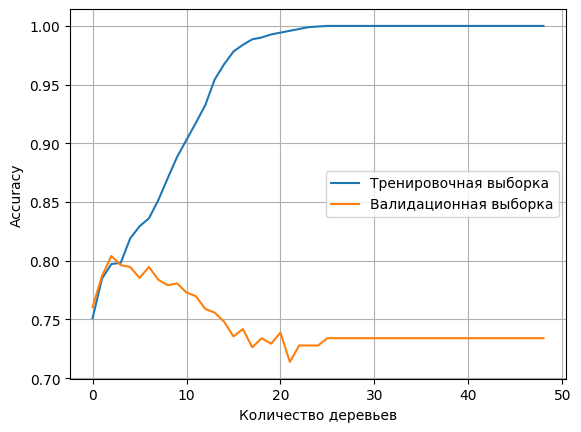

In [13]:
# Списки, в которые будем сохранять accuracy по train и validation
ac_train = []
ac_valid = []

# Меняем в цикле значение max_depth у нашего дерева
# и записываем значения accuracy по train и validation в два списка
for depth in range(1,50):
    model_tree = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model_tree.fit(features_train, target_train) 
    pred_train=model_tree.predict(features_train)
    accuracy_train=accuracy_score(target_train, pred_train) # accuracy по train
    ac_train.append(accuracy_train)
    pred_val=model_tree.predict(features_val)
    accuracy_val=accuracy_score(target_val, pred_val) # accuracy по validation
    ac_valid.append(accuracy_val)

# Строим графики по значениям accuracy
plt.plot(ac_train, label='Тренировочная выборка');
plt.plot(ac_valid, label='Валидационная выборка');
plt.xlabel('Количество деревьев')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

На графике видно, что наиболее высокий показатель метрики accuracy наблюдается на отметке 3 дерева.

Посмотрим, как выглядит наше дерево с оптимальными гиперпараметрами.

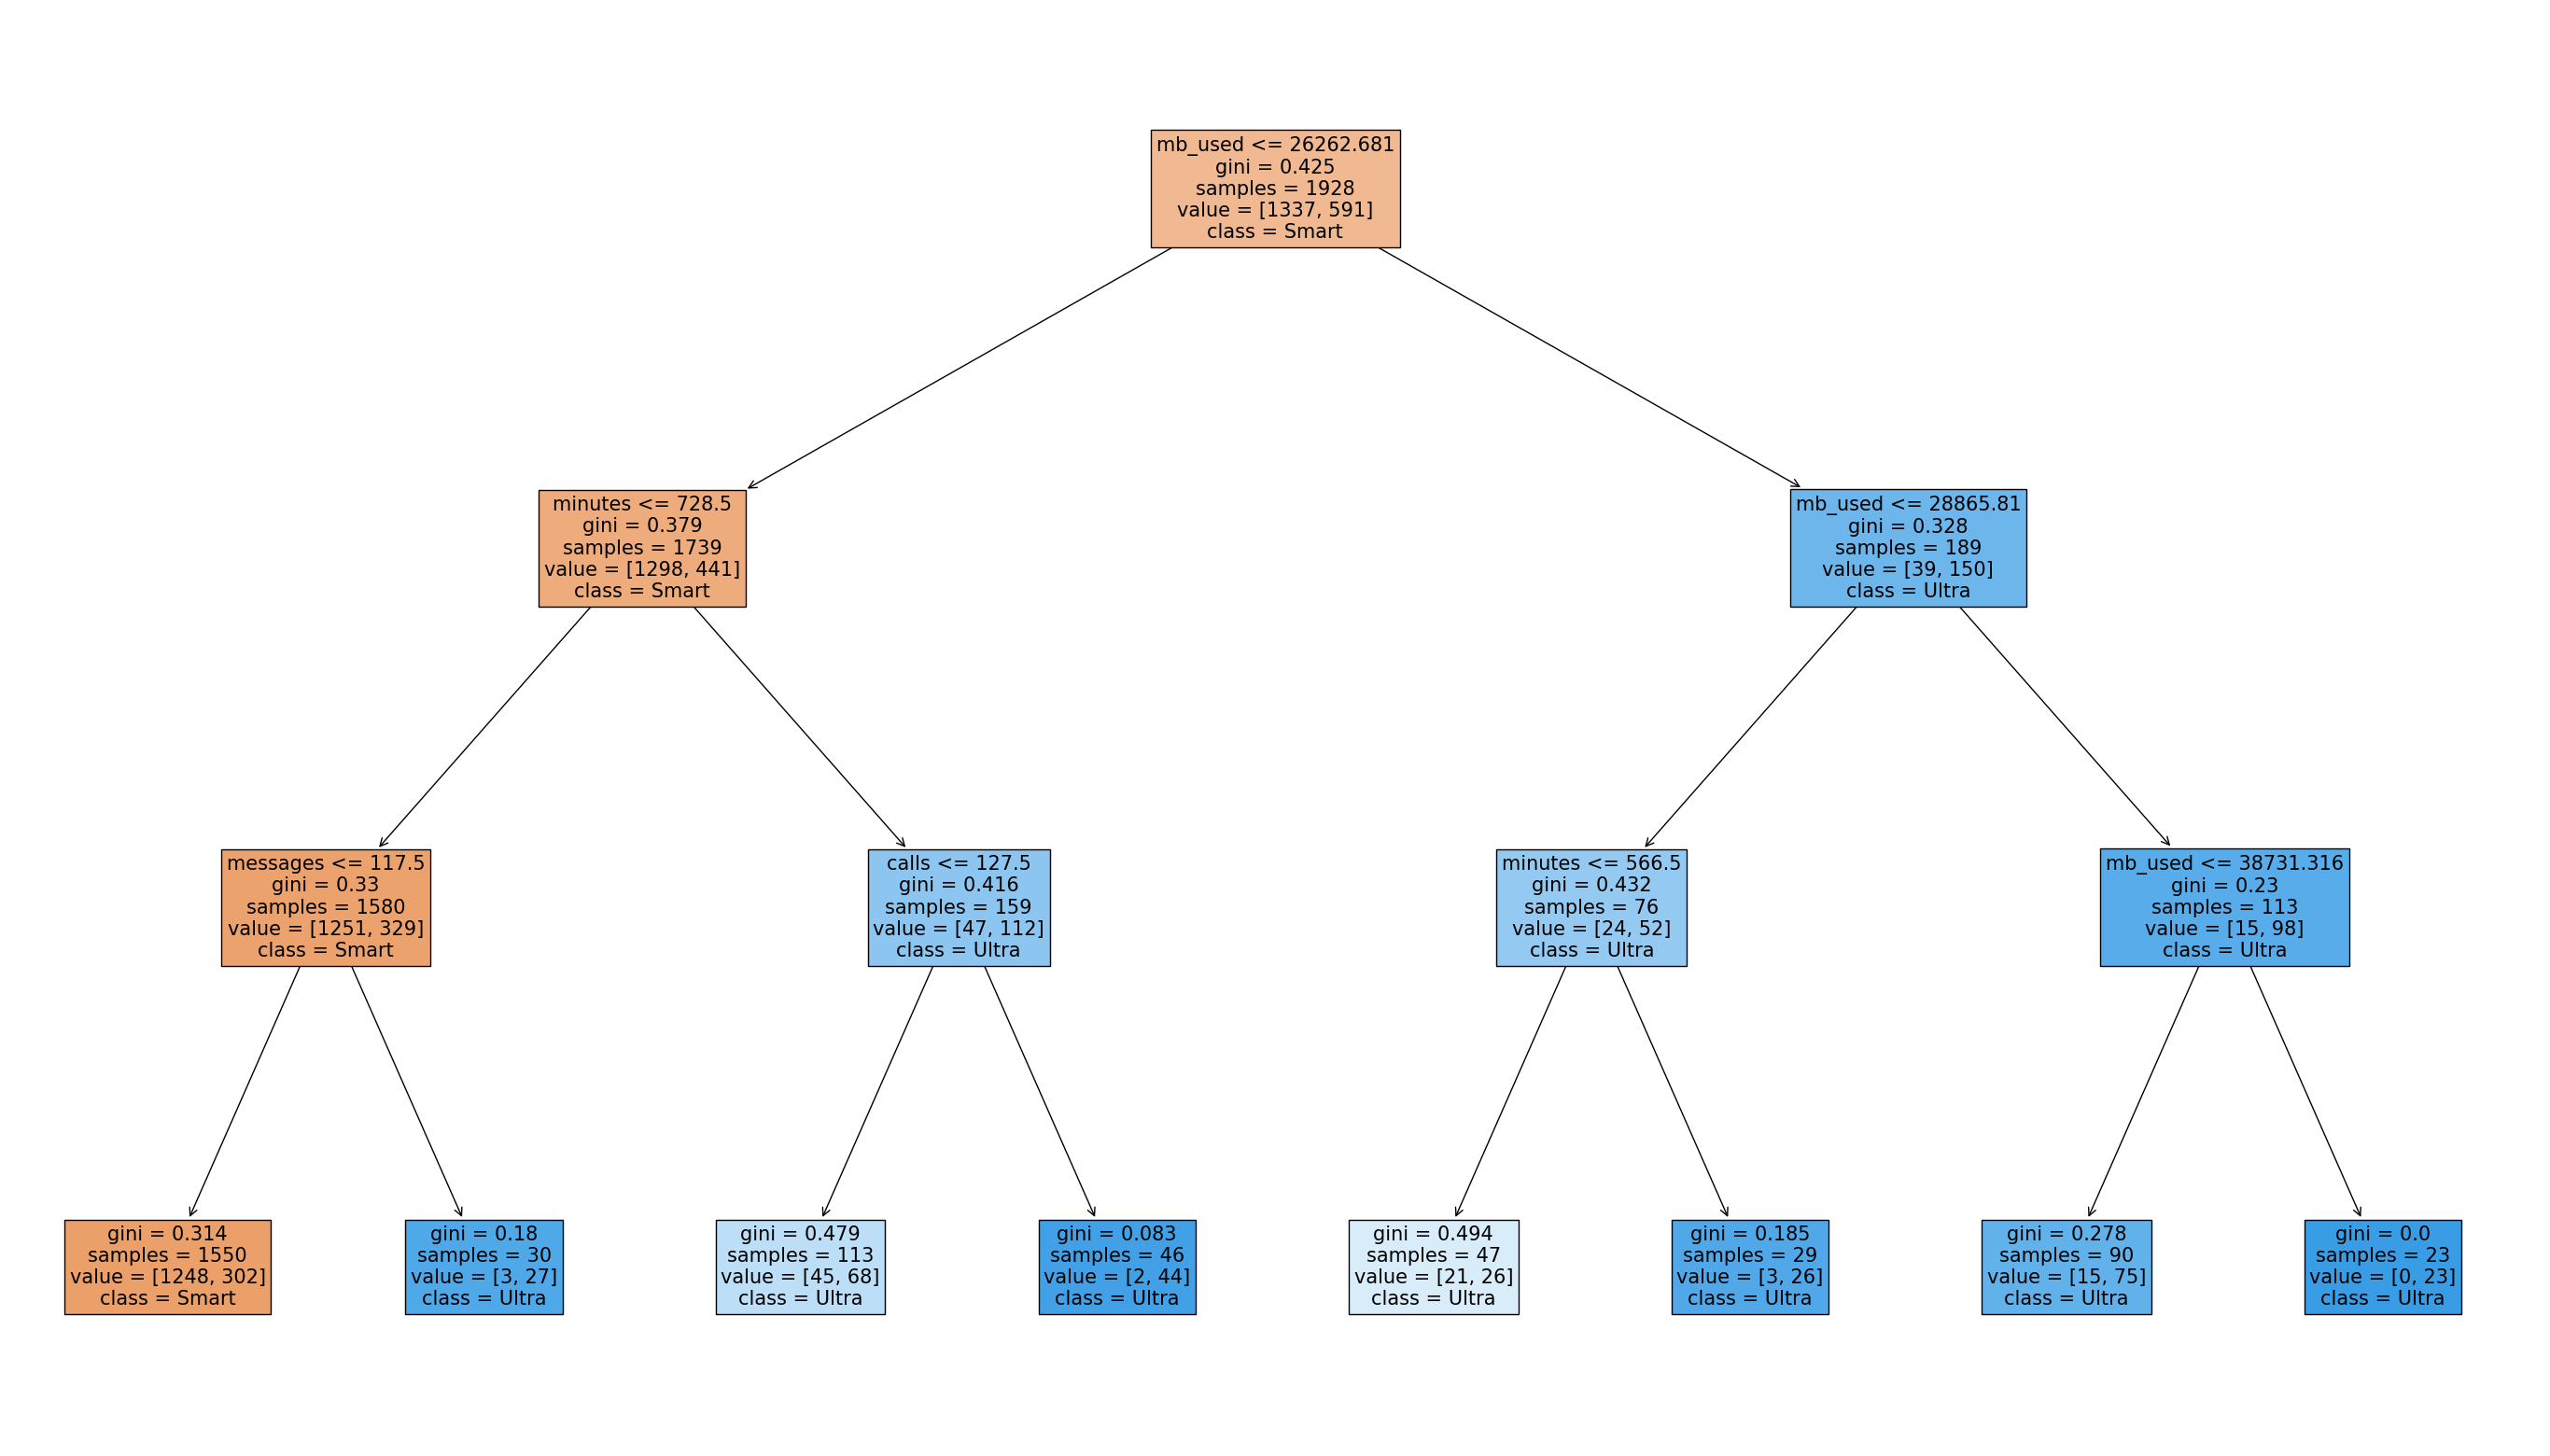

In [14]:
fig = plt.figure(figsize=(35,20))
_ = tree.plot_tree(best_model_dt, 
               feature_names=features.columns.values, 
               class_names=['Smart','Ultra'],
               filled=True,
               fontsize = 15)

### Случайный лес

In [15]:
# Проверяем, как меняется качество модели в зависимости от параметров max_depth
# и n_estimators и выводим информацию о модели с наилучшим показателем

best_accuracy_rf = 0
best_depth = None
best_est = None
best_model_rf = None

for depth in range(1,6):
    for est in range(1,10):
        model_forest = (RandomForestClassifier 
                  (random_state=42, max_depth=depth, n_estimators = est)
                 )
        model_forest.fit(features_train, target_train) 
        # обучаем модель на тренировочной выборке
        
        predictions=model_forest.predict(features_val) 
        # предсказываем на валидационной выборке
        
        accuracy=accuracy_score(target_val, predictions) #считаем accuracy 
        
        if accuracy > best_accuracy_rf: 
            best_accuracy_rf = accuracy
            best_depth = depth
            best_model_rf = model_forest
            best_est = est
        
print(f'Accuracy лучшей модели: {best_accuracy_rf}, \
глубина: {best_depth}, деревьев: {best_est}')


Accuracy лучшей модели: 0.8087091757387247, глубина: 3, деревьев: 9


Попробуем теперь подобрать гиперпараметры модели с использованием модуля GridSearchCV.

In [16]:
%%time
model_rf = RandomForestClassifier(random_state=42)
parameters_rf = {'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13,2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2)}
grid_rf = GridSearchCV(model_rf, parameters_rf)
grid_rf.fit(features_train, target_train)
grid_rf.best_params_

CPU times: user 6min 56s, sys: 1.8 s, total: 6min 57s
Wall time: 7min 10s


{'max_depth': 11,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 20}

Посмотрим, как изменилось значение accuracy в модели с автоматически подобранными гиперпараметрами через GridSearch по сравнению с моделью, гиперпараметры которой мы проверяли в цикле.

In [17]:
print(f'Accuracy модели по GridSearch: {grid_rf.best_score_}')
print(f'Accuracy модели c гиперпараметрами, подобранными в цикле: {best_accuracy_rf}')

Accuracy модели по GridSearch: 0.8111984388668327
Accuracy модели c гиперпараметрами, подобранными в цикле: 0.8087091757387247


Как видим, accuracy различается незначительно, на модели с гиперпараметрами, подобранными через GridSearch, этот показатель немного выше. 

### Логистическая регрессия

In [18]:
# Обучаем модель и считаем accuracy

model_regression = (LogisticRegression
                    (random_state=12345, solver='lbfgs', max_iter=1000)
                   )

model_regression.fit(features_train, target_train)

predictions = model_regression.predict(features_val)

accuracy = model_regression.score(features_train, target_train)

print(f'Accuracy модели логистической регрессии: {accuracy}')


Accuracy модели логистической регрессии: 0.7442946058091287


### Вывод по разделу
Из трех исследованных моделей наилучший результат по метрике accuracy показала модель, построенная по алгоритму случайного леса с гиперпараметрами: {'max_depth': 11, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 20}.

## Проверка модели на тестовой выборке

Чтобы улучшить параметры модели, перед проверкой на тестовой выборке увеличим объем данных, на которых она будет обучаться (добавим в обучающую выборку значения из валидационной).

In [19]:
# Объединяем обучающую и валидационную выборки
test_val_features = pd.concat([features_test, features_val])
test_val_target = pd.concat([target_test, target_val])

# Проверяем размер новых данных
print(test_val_features.shape)
test_val_target.shape


(1286, 4)


(1286,)

In [20]:
# Обучаем модель на расширенной выборке
grid_rf.best_estimator_.fit(test_val_features, test_val_target)

RandomForestClassifier(max_depth=11, min_samples_leaf=5, n_estimators=20,
                       random_state=42)

In [21]:
# Делаем предсказания на тестовой выборке
predictions = grid_rf.best_estimator_.predict(features_test) 

# Считаем accuracy по тестовой выборке
accuracy_rf_test = accuracy_score(target_test, predictions) 

print(f'Accuracy модели "случайный лес" на тестовой выборке: {accuracy_rf_test}')

Accuracy модели "случайный лес" на тестовой выборке: 0.8709175738724728


### Вывод по разделу
У модели, которая показала лучший результат на валидационной выборке, показатель accuracy на тестовой выборке составляет 0.87. Цель исследования достигнута.

## Проверка модели на адекватность

Чтобы проверить, насколько адекватна наша модель, мы сравним ее предсказания с результатом работы случайной модели.

Ранее мы проверяли, сколько значений 0 и 1 содержится в нашем целевом столбце. Посмотрим еще раз.

In [22]:
df.is_ultra.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Как видим, в данных имеется дисбаланс. Будем учитывать это при проверке.

In [23]:
# Создаем случайную модель и смотрим на ее точность
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features_train, target_train)
dummy_accuracy = accuracy_score(dummy_clf.predict(features_test), target_test)
print(f'Accuracy случайного леса на тестовой выборке: {accuracy_rf_test}')
print(f'Accuracy случайной модели: {dummy_accuracy}')
print(f'Разница: {accuracy_rf_test - dummy_accuracy}')

Accuracy случайного леса на тестовой выборке: 0.8709175738724728
Accuracy случайной модели: 0.6936236391912908
Разница: 0.17729393468118204


### Вывод по разделу
Сравнение предсказаний, сделанных нашей моделью на тестовой выборке, с предсказаниями случайной модели показало, что наша модель является адекватной, поскольку aссuracy случайной модели существенно меньше, чем этот показатель по нашей модели.

## Вывод по проекту

В результате проведенного исследования была выбрана модель с наибольшим показателем метрики accuracy. Это модель, построенная по алгоритму случайного леса со следующими гиперпараметрами: {'max_depth': 11, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 20}. 

Показатель accuracy этой модели на валидационной выборке составил 0.81, на тестовой — 0.87. 

Сравнение предсказаний нашей модели и дамми-модели говорит в пользу адекватности нашей модели.

Таким образом, мы построили и обучили модель, которая может предлагать пользователям тариф «Ультра» или «Смарт» в зависимости от их поведения (то есть в зависимости от параметров, которые отражены в данных).